## Cryptocurrency Transactions Notebook

In this notebook, we read data on cryptocurrency assets and derive insights from it.

### Contents
1. [Coinhacko: Average transaction price of each asset](#section1)
2. [Coinhacko: Comparison with current asset price](#section2)
3. [Binance](#section3)
4. [Combining Data](#section4)
5. [Visualisation](#section5)

### 1 - Average transaction price of each asset <a name="section1"></a>

Reading the contents of each file generated by cryptocurrency exchange.

In [1]:
import pandas as pd
coinhako = pd.read_csv("transactions/01_Coinhako_Trade History.csv")

coinhako.head()

,Pair,Side,Type,Average Price,Price,Amount,Executed,Fee,Total,Status,Time & Date
0,DOT/SGD,Sell,Instant Order,--,59.476800,17.458356,--,6.230203,1032.140000,Completed,3/4/2021 22:28
1,UNI/SGD,Sell,Instant Order,--,34.513400,7.957171,--,2.197032,272.430000,Completed,22/2/2021 20:03
2,BAND/BTC,Swap,Instant Order,--,0.000291,5.721537,--,0.000013,0.001652,Completed,22/2/2021 16:56
3,LINK/BTC,Swap,Instant Order,--,0.000607,3.338482,--,0.000016,0.002010,Completed,21/2/2021 11:16
4,BTC/SGD,Buy,Instant Order,--,59607.590000,100.000000,--,0.800000,0.001664,Completed,11/2/2021 1:31


We get data for Buy/Sell transactions.

For this section, we will leave out the "Swap" data.

In [2]:
import numpy as np

coinhako_ = coinhako[coinhako['Side']!='Swap'].groupby(['Pair', 'Side']).agg({'Total':'sum', 'Amount':'sum', 'Fee':'sum'})
coinhako_.reset_index(inplace=True)
#coinhako_['Fee (%)'] = (coinhako_['Fee']/coinhako_['Amount'])*100
coinhako_['Average Buying/Selling Price'] = np.where(coinhako_['Side']=='Buy', coinhako_['Amount']/coinhako_['Total'], coinhako_['Total']/coinhako_['Amount'])
coinhako_ = coinhako_.rename(columns={'Total': 'Units of Assets', 'Amount':'Total Cost of Assets', 'Fee':'Total Fee'})
coinhako_['Asset'] = coinhako_['Pair'].str.split("/", expand=True)[0]
coinhako_['Current asset price'] = np.nan
coinhako_.head()

,Pair,Side,Units of Assets,Total Cost of Assets,Total Fee,Average Buying/Selling Price,Asset,Current asset price
0,BAND/SGD,Buy,5.721537,100.000000,0.800000,17.477823,BAND,NaN
1,BTC/SGD,Buy,0.038008,1730.000000,16.200000,45517.015944,BTC,NaN
2,DOT/SGD,Buy,17.458356,400.000000,3.200000,22.911664,DOT,NaN
3,DOT/SGD,Sell,1032.140000,17.458356,6.230203,59.120113,DOT,NaN
4,ETH/SGD,Buy,0.693040,950.000000,9.300000,1370.771985,ETH,NaN


### 2 - Comparision wth current asset price <a name="section2"></a>

To create a function that uses cryptocompare library to automatically get the current price of asset

In [3]:
import cryptocompare
price = cryptocompare.get_price('BTC', 'SGD')

def  get_crypto_price(asset):
    return cryptocompare.get_price(asset, 'SGD')[asset]['SGD']

print(get_crypto_price('BTC'))

66453.6


Add a column for CURRENT asset price in SGD

### 3 - Binance <a name="section3"></a>

In [4]:
binance = pd.read_csv("transactions/05_Binance_Trade History.csv")

binance.head()

,Date(UTC),Pair,Side,Price,Executed,Amount,Fee
0,2021-04-27 08:47:14,MATICBUSD,SELL,0.6100000000,163.9000000000MATIC,99.97900000BUSD,0.0000000000BNB
1,2021-04-25 20:50:54,BTCBUSD,BUY,"48,500.0000000000",0.0010300000BTC,49.95500000BUSD,0.0000000000BNB
2,2021-04-22 20:27:24,BTCBUSD,BUY,"52,000.0000000000",0.0019230000BTC,99.99600000BUSD,0.0000000000BNB
3,2021-04-18 16:38:27,BTCBUSD,BUY,"55,700.0000000000",0.0017950000BTC,99.98150000BUSD,0.0000000000BNB
4,2021-04-18 09:03:12,ETHBUSD,BUY,"2,130.0000000000",0.0469400000ETH,99.98220000BUSD,0.0000000000BNB


Data is messy and improper form, we have to do some cleaning.

In [5]:
binance['Executed'] = binance.Executed.str.replace(r"[a-zA-Z,]",'')
binance['Amount'] = binance.Amount.str.replace(r"[a-zA-Z]",'')
binance['Fee'] = binance.Fee.str.replace(r"[a-zA-Z]",'')
binance['Executed'] = binance['Executed'].astype(float)
binance['Amount'] = binance['Amount'].astype(float)
binance['Fee'] = binance['Fee'].astype(float)

Binance has mainly in USD, so we need a foreign exchange library

In [6]:
from forex_python.converter import CurrencyRates

c = CurrencyRates()

rate = c.get_rate('USD', 'SGD')

print(rate)

1.3330858698


In [7]:
binance_ = binance.groupby(['Pair', 'Side']).agg({'Executed':'sum', 'Amount':'sum','Fee':'sum'})
binance_.reset_index(inplace=True)
binance_['Side'] = binance_['Side'].str.title()
#binance_['Fee (%)'] = (binance_['Fee']/binance_['Amount'])*100
binance_['Average Buying/Selling Price'] = binance_['Amount']/binance_['Executed']
binance_ = binance_.rename(columns={'Amount': 'Total Cost of Assets', 'Executed':'Units of Assets', 'Fee':'Total Fee'})
#Get the Asset Pair
binance_['Asset'] = binance_['Pair'].apply(lambda x: x[:-4:] if x[-4:] == 'BUSD' else x[:-3])

#Convert Cost in USD to SGD
binance_['Total Cost of Assets'] = binance_['Total Cost of Assets']*rate
binance_['Average Buying/Selling Price'] = binance_['Average Buying/Selling Price']*rate


binance_['Current asset price'] = np.nan
binance_.head()

,Pair,Side,Units of Assets,Total Cost of Assets,Total Fee,Average Buying/Selling Price,Asset,Current asset price
0,1INCHBTC,Sell,15.00,0.002030,0.000169,0.000135,1INCH,NaN
1,1INCHBUSD,Buy,47.61,266.566517,0.000000,5.598961,1INCH,NaN
2,1INCHBUSD,Sell,18.18,133.295256,0.000000,7.331972,1INCH,NaN
3,ADABUSD,Buy,475.80,661.497205,0.000000,1.390284,ADA,NaN
4,ADABUSD,Sell,65.70,133.127287,0.000000,2.026291,ADA,NaN


### 4 - Combining Data <a name="section4"></a>

Combine both Coinhako and Binance data tables

In [8]:
coinhako_ = coinhako_.drop(['Average Buying/Selling Price'], axis=1)
binance_ = binance_.drop(['Average Buying/Selling Price'], axis = 1)

In [9]:
merged = pd.concat([coinhako_, binance_]).groupby(['Asset', 'Side']).sum().reset_index()
merged.head()

,Asset,Side,Units of Assets,Total Cost of Assets,Total Fee,Current asset price
0,1INCH,Buy,47.61,266.566517,0.000000,0.0
1,1INCH,Sell,33.18,133.297286,0.000169,0.0
2,ADA,Buy,475.80,661.497205,0.000000,0.0
3,ADA,Sell,65.70,133.127287,0.000000,0.0
4,ALGO,Buy,300.18,533.218951,0.000000,0.0


Now that the dataframe is merged, we add a few columns:
- Current asset price
- Calculate the Average Buying/Selling Price
- Calculate Paper Gain based on the Current Asset price
- Syntax Highlighting

In [10]:
merged['Average Buying/Selling Price'] = np.where(merged['Side']=='Buy', merged['Total Cost of Assets']/merged['Units of Assets'], merged['Units of Assets']/merged['Total Cost of Assets'])

for i in range(0, merged.shape[0]):
    merged['Current asset price'][i] = get_crypto_price(merged['Asset'][i])
    
merged['Paper Gain'] = np.where(merged['Side'] == 'Buy', 
                        (merged['Current asset price']*merged['Units of Assets'])-merged['Total Cost of Assets'], 0)

merged['Gain %'] = ((merged['Paper Gain']/merged['Total Cost of Assets'])*100).round(2)
                            

def apply_formatting(col):
    if col.name == 'Side':
        return ['color: red' if c == "Sell" else 'color: green' for c in col.values]
    if col.name == 'Paper Gain':
        return ['color: green' if c > 0 else 'color:red' for c in col.values]
    if col.name == 'Gain %':
        return ['color:green' if c > 0 else 'color:red' for c in col.values]


merged.sort_values(by=['Side', 'Gain %'], ascending=[True, False], inplace=True)
merged.style.apply(apply_formatting, subset=['Side', 'Paper Gain', 'Gain %'])

<ipython-input-10-b1094f19aad0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged['Current asset price'][i] = get_crypto_price(merged['Asset'][i])


,Asset,Side,Units of Assets,Total Cost of Assets,Total Fee,Current asset price,Average Buying/Selling Price,Paper Gain,Gain %
26,MATIC,Buy,1657.500000,396.175619,0.000398,2.165000,0.239020,3192.311881,805.780000
6,BAKE,Buy,269.250000,399.767877,0.000000,8.286000,1.484746,1831.237623,458.080000
18,ETH,Buy,1.372350,2482.934216,9.300358,5080.210000,1809.257094,4488.892659,180.790000
32,TRX,Buy,2016.100000,133.306667,0.000000,0.173400,0.066121,216.285073,162.250000
2,ADA,Buy,475.800000,661.497205,0.000000,3.213000,1.390284,867.248195,131.100000
36,XLM,Buy,249.300000,133.267661,0.000000,1.013000,0.534567,119.273239,89.500000
24,LTC,Buy,7.215186,1762.063553,0.302523,428.360000,244.215964,1328.633438,75.400000
11,CAKE,Buy,22.460000,532.541370,0.000000,40.470000,23.710658,376.414830,70.680000
15,DOT,Buy,47.788356,1730.957867,3.200678,61.410000,36.221331,1203.725102,69.540000
23,LINK,Buy,30.918482,1098.593998,0.800000,59.060000,35.531951,727.451573,66.220000


### 5 - Visualisation <a name="section5"></a>

Data visulisation for the visual client.

Top 5 asset holdings by Percentage Gain/Loss

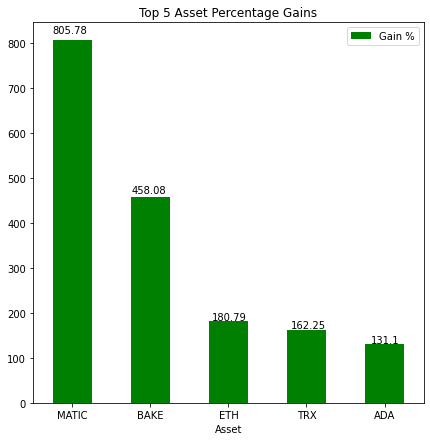

In [11]:
top5gain = merged.sort_values(by=['Gain %'], ascending=False)

ax = top5gain.head().plot(x="Asset", y="Gain %", kind="bar", color="g", rot=0, title="Top 5 Asset Percentage Gains", figsize=(7,7))

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.02))

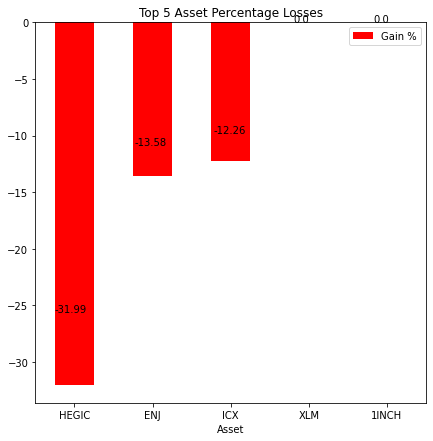

In [12]:
top5losses = merged.sort_values(by=['Gain %'], ascending=True)

ax = top5losses.head().plot(x="Asset", y="Gain %", kind="bar", color="r", rot=0, title="Top 5 Asset Percentage Losses", figsize=(7,7))

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 0.8))

Paper Portfolio value based on current Asset Prices, categoried by Gains/Losses

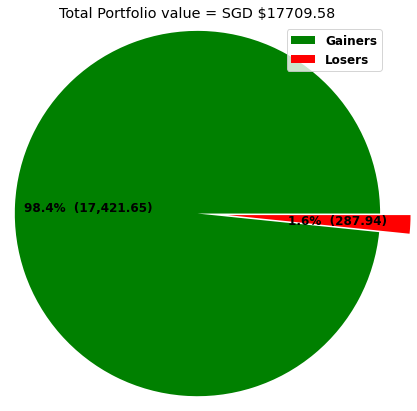

In [13]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12.0
plt.rcParams["font.weight"] = "bold"
transaction_type =['Gainers', 'Losers']
paper_value = [merged.loc[merged['Paper Gain']>0, 'Total Cost of Assets'].sum(), merged.loc[merged['Paper Gain']<0, 'Total Cost of Assets'].sum()]

fig = plt.figure(figsize =(10, 7))
plt.pie(paper_value, explode=(0, 0.2), autopct=lambda p : '{:.1f}%  ({:,.2f})'.format(p,p * sum(paper_value)/100), radius=1.2, colors=['green', 'red'])
plt.title(f"Total Portfolio value = SGD ${sum(paper_value):.2f}")
plt.legend(transaction_type)
plt.show()